In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.signal import butter, filtfilt, welch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

### Load Dataset

In [3]:
eeg_predictive_train = np.load('../data/eeg-predictive_train.npz')
eeg_predictive_val_balanced = np.load('../data/eeg-predictive_val_balanced.npz')
eeg_predictive_val = np.load('../data/eeg-predictive_val.npz')
signals, labels = eeg_predictive_train['train_signals'], eeg_predictive_train['train_labels']
signals_val, labels_val = eeg_predictive_val_balanced['val_signals'], eeg_predictive_val_balanced['val_labels']
signals_val_unbalanced, labels_val_unbalanced = eeg_predictive_val['val_signals'], eeg_predictive_val['val_labels']


In [ ]:
eeg_seizure_train = np.load('../data/eeg-seizure_train.npz')
eeg_seizure_val_balanced = np.load('../data/eeg-seizure_val_balanced.npz')

signals_seizure, labels_seizure = eeg_seizure_train['train_signals'], eeg_seizure_train['train_labels']
signals_seizure_test, labels_seizure_test = eeg_seizure_val_balanced['val_signals'], eeg_seizure_val_balanced['val_labels']

### Preprocess and Reduce Dimensionality

In [4]:
def preprocess(signals):
    # Parameters
    fs = 256  # Sampling frequency in Hz
    bandpass_lowcut = 0.5  # Lower cutoff frequency in Hz
    bandpass_highcut = 60.0  # Upper cutoff frequency in Hz

    # Create the Butterworth bandpass filter
    def butter_bandpass(bandpass_lowcut, bandpass_highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = bandpass_lowcut / nyquist
        high = bandpass_highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    # Apply zero-phase Butterworth bandpass filter using filtfilt
    def bandpass_filter(data, bandpass_lowcut, bandpass_highcut, fs, order=4):
        b, a = butter_bandpass(bandpass_lowcut, bandpass_highcut, fs, order=order)
        # Apply along the last axis (time axis)
        filtered_data = filtfilt(b, a, data, axis=-1)
        return filtered_data

    # Example 3D EEG data (samples x channels x time)
    eeg_data = signals

    # Apply the filter to the EEG data
    filtered_eeg = bandpass_filter(eeg_data, bandpass_lowcut, bandpass_highcut, fs)

    # Example 3D EEG data (samples x channels x time)
    eeg_data = filtered_eeg

    # Compute the common average reference
    mean_across_channels = np.mean(eeg_data, axis=1, keepdims=True)  # Shape: (samples, 1, time)

    # Subtract the mean from each channel
    car_filtered_data = eeg_data - mean_across_channels

    # Parameters
    lowcut = 2  # Lower cutoff frequency in Hz
    highcut = 40  # Upper cutoff frequency in Hz
    epoch_duration = 0.5  # Duration of each epoch in seconds
    nperseg = int(epoch_duration * fs)  # Number of samples per segment (128 for 0.5 seconds at 256 Hz)

    # Example 3D EEG data (samples x channels x time)
    samples, channels, _ = car_filtered_data.shape
    eeg_data = car_filtered_data

    # Define a function to calculate spectral power in the desired frequency range
    def compute_spectral_power(data, fs, lowcut, highcut, nperseg):
        freqs, psd = welch(data, fs=fs, window='hann', nperseg=nperseg, nfft=nperseg)
        # Select only the frequencies in the range [lowcut, highcut]
        idx_band = np.logical_and(freqs >= lowcut, freqs <= highcut)
        band_power = np.sum(psd[idx_band])
        return band_power

    # Compute spectral power for each sample and channel
    spectral_features = np.zeros((samples, channels, highcut - lowcut + 1))

    for i in range(samples):
        for j in range(channels):
            spectral_features[i, j, :] = compute_spectral_power(eeg_data[i, j, :], fs, lowcut, highcut, nperseg)
    
    spectral_features = spectral_features.reshape(samples, -1)

    return spectral_features

In [5]:
def zscore_2d(arr):
    # Along the time dimension 
    means = np.mean(arr, axis=(0), keepdims=False)
    stds = np.std(arr, axis=(0), keepdims=False)
    
    zscored_arr = (arr - means) / stds
    
    return zscored_arr

In [6]:
X_train = preprocess(signals)
X_val = preprocess(signals_val)
X_val_unbalanced = preprocess(signals_val_unbalanced)

In [7]:
X_train_no_preprocess = np.mean(signals, axis=2)
X_val_no_preprocess = np.mean(signals_val, axis=2)
X_val_unbalanced_no_preprocess = np.mean(signals_val_unbalanced, axis=2)

In [8]:
variances = np.var(X_train, axis=0)
sorted_variances = np.argsort(variances)[-18:]
X_train_top = X_train[:, sorted_variances]
X_val_top = X_val[:, sorted_variances]
X_train_top = zscore_2d(X_train_top)
X_val_top = zscore_2d(X_val_top)

In [9]:
X_train_no_preprocess = zscore_2d(X_train_no_preprocess)
X_val_no_preprocess = zscore_2d(X_val_no_preprocess)
X_val_unbalanced_no_preprocess = zscore_2d(X_val_unbalanced_no_preprocess)

In [10]:
X_train_std = zscore_2d(X_train)
X_val_std = zscore_2d(X_val)
X_val_unbalanced_std = zscore_2d(X_val_unbalanced)

In [11]:
pca = PCA(n_components=.99)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_val_unbalanced_pca = pca.transform(X_val_unbalanced_std)

In [12]:
pca = PCA(n_components=.99)
X_train_no_pre_pca = pca.fit_transform(X_train_no_preprocess)
X_val_no_pre_pca = pca.transform(X_val_no_preprocess)
X_val_unbalanced_no_pre_pca = pca.transform(X_val_unbalanced_no_preprocess)

In [13]:
y_train = labels
y_val = labels_val
y_val_unbalanced = labels_val_unbalanced

### Perform SVM and LDA classification

In [ ]:
from sklearn import svm

# Train an SVM with the RBF kernel
clf = svm.SVC(kernel='rbf', class_weight='balanced', C=35)  # Adjust gamma as needed
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_val_unbalanced_pca)
accuracy = accuracy_score(y_val_unbalanced, y_pred)

print("Test accuracy with RBF kernel:", accuracy)
print("Recall", np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1))

Test accuracy with RBF kernel: 0.673734610123119
Recall 0.3628048780487805


In [145]:
C_vals = [0.1, 1, 10, 15, 20, 50]
accuracies = []
recalls = []
precisions = []
TNRs = []

for C in C_vals:
    clf = svm.SVC(kernel='rbf', class_weight='balanced', C=C)
    clf.fit(X_train_no_preprocess, y_train)

    # Make predictions and evaluate
    y_pred = clf.predict(X_val_unbalanced_no_preprocess)
    accuracy = accuracy_score(y_val_unbalanced, y_pred)
    accuracies.append(accuracy)
    recall = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1)
    recalls.append(recall)
    precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1)
    precisions.append(precision)
    TNR = np.sum(y_pred[y_val_unbalanced == 0] == 0) / np.sum(y_val_unbalanced == 0)
    TNRs.append(TNR)

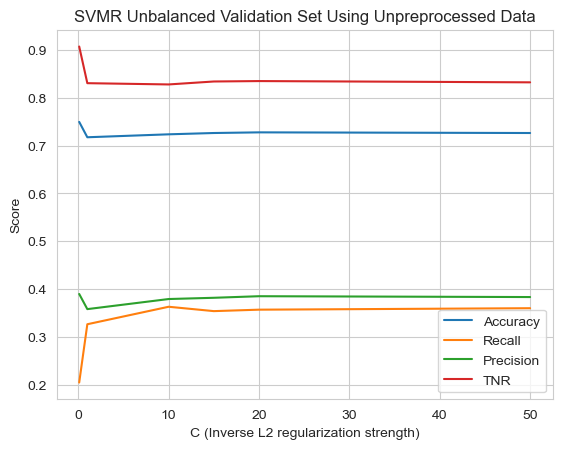

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')

plt.plot(C_vals, accuracies, label='Accuracy')
plt.plot(C_vals, recalls, label='Recall')
plt.plot(C_vals, precisions, label='Precision')
plt.plot(C_vals, TNRs, label='TNR')
plt.legend()
plt.xlabel('C (Inverse L2 regularization strength)')
plt.ylabel('Score')
plt.title('SVMR Unbalanced Validation Set Using Unpreprocessed Data')
# plt.savefig('images/svmr_unbalanced_unpreprocessed_data.png')

plt.show()

In [131]:
y_pred_train = clf.predict(X_train_pca)

In [132]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_train

0.37068340980439507

In [122]:
np.unique(y_pred_train, return_counts=True)

(array([0., 1.]), array([1687, 6595]))

SVMR Using .99 PCA of Preprocessed Signal: .645

SVMR Using Normalized Original Signals: .602

SVMR Using Normalized Original Signals with PCA: .607

SVMR Using Preprocessed Signal: .591

SVMR Using Preprocessed Signal on Unbalanced Data: .694 Recall: .329

SVMR Using Normalized Original Signals on Unbalanced Data: .728 Recall: .357

SVMR Using Normalized Original Signals with PCA on Unbalanced Data: .722 Recall: .357

SVMR Using .99 PCA of Preprocessed Signal on Unbalanced Data: .67 Recall: .363


In [159]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class_counts = np.bincount(y_train.astype(int))
class_priors = class_counts / len(y_train)

# Initialize LDA model
lda = LinearDiscriminantAnalysis(priors=class_priors)

# Train LDA model
lda.fit(X_train_no_preprocess, y_train)

# Predict on test data
y_pred = lda.predict(X_val_unbalanced_no_preprocess)

# Evaluate accuracy
accuracy = accuracy_score(y_val_unbalanced, y_pred)
recall = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1)
precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1)
TNR = np.sum(y_pred[y_val_unbalanced == 0] == 0) / np.sum(y_val_unbalanced == 0)

print(f"Accuracy: {accuracy:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}, TNR: {TNR:.2f}")

Accuracy: 0.78, Recall: 0.00, Precision: nan, TNR: 1.00


/var/folders/df/1xb8490s40l3kj44bs6x9w980000gn/T/ipykernel_4090/4006021060.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1)


In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [16, 18, 19, 20], 'kernel': ['rbf'], 'class_weight': ['balanced']}
grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_std, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 20, 'class_weight': 'balanced', 'kernel': 'rbf'}


For unbalanced dataset validation best C is 20+ and for balanced dataset best C is 15-18

### DMNN

In [14]:
def max_s_x(centers, rs, x):
    s_c = x[:, np.newaxis, :] - centers
    norm_s_c = np.linalg.norm(s_c, axis=2)
    r_norm = rs - norm_s_c
    return r_norm.max(axis=1)

def get_centroids_radii(kmeans, X):
    centroids = kmeans.cluster_centers_
    radii = []
    for i in range(len(centroids)):
        cluster_points = X[kmeans.labels_ == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        radii.append(distances.max())
    
    return centroids, np.array(radii)

def error_calculation(excluded_X, inc_X, kmeans):
    centroids, radii = get_centroids_radii(kmeans, inc_X)
    max_s_all_X = max_s_x(centroids, radii, excluded_X)
    return np.sum(max_s_all_X > 0) / len(max_s_all_X)


In [15]:
rand_sample_ind = np.random.choice(np.where(y_train == 0)[0], 6364, replace=False)
X_train_balanced = np.concatenate((X_train_pca[rand_sample_ind], X_train_pca[y_train == 1]))
y_train_balanced = np.concatenate((y_train[rand_sample_ind], y_train[y_train == 1]))
X_train = X_train_pca[rand_sample_ind]
y_train = labels.astype(int)
X_val = X_val_unbalanced_pca
y_val = y_val_unbalanced

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [17]:
import torch
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=.99, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [ ]:
from tqdm import tqdm

ce_loss = nn.CrossEntropyLoss(reduction='mean', weight=class_weights)
focal_loss = FocalLoss()

class Spherical_Denrite(nn.Module):
    def __init__(self, c, r):
        super(Spherical_Denrite, self).__init__()
        self.centroid = nn.Parameter(torch.tensor(c, dtype=torch.float32), requires_grad=True)
        self.radii    = nn.Parameter(torch.tensor(r, dtype=torch.float32), requires_grad=False)

    def forward(self, x):
        # print(x.shape)
        # print(self.centroid.shape)
        distance = torch.sqrt(torch.clamp(torch.pow(x - self.centroid, 2).sum(1), min=1e-10))
        x = self.radii - distance # n x 1 where n is the number of samples
        return x
    
class SmoothMaximum(nn.Module):
    def __init__(self,beta=1.0):
        super(SmoothMaximum, self).__init__()
        self.beta = beta
        self.softmax = nn.Softmax(dim = 1) 
    def forward(self, dendrite_activations):
        # Dendrite activations is n x m_k where n is the number of samples and m_k is the number of dendrites in cluster k
        softmax = self.softmax(self.beta * dendrite_activations)
        return torch.sum(softmax * dendrite_activations, dim=1) # n x 1 where n is the number of samples
    

class DMNN(nn.Module):
    def __init__(self, data, labels, error_thresold, classes=2):
        super(DMNN, self).__init__()
        self.classes = classes
        self.spherical_dendrites = nn.ModuleList()
        self.output_nodes = nn.ModuleList([nn.Linear(classes, 1, bias=True) for _ in range(classes)])
        print("Initializing Spherical Dendrites using KMeans...")
        self.initialize_spherical_dendrites(data, labels, error_thresold)
        self.smoothmax = SmoothMaximum()

    def forward(self, inp):
        inp = inp.reshape(inp.shape[0], -1)
        dendrite_cluster = []
        for class_dendrites in self.spherical_dendrites:
            cluster_activations = []
            for dendrite in class_dendrites:
                cluster_activations.append(dendrite(inp))

            cluster_activations = torch.stack(cluster_activations, dim=1)
            
            out = self.smoothmax(cluster_activations)

            dendrite_cluster.append(out)

        dendrite_cluster = torch.stack(dendrite_cluster, dim=1)
        class_node_activations = []
        for output_node in self.output_nodes:
            class_node_activations.append(output_node(dendrite_cluster))
        out = torch.stack(class_node_activations, dim=1)
        return out
    
    def initialize_spherical_dendrites(self, X_train, y_train, error_thresold):
        for class_ind in range(self.classes):
            in_class = X_train[y_train == class_ind]
            out_class = X_train[y_train != class_ind]
            num_clusters = int(in_class.shape[0] * .4)
            below_error = False
            cluster_pbar = tqdm(desc=f"Finding Optimal Clusters with Error Thresold {error_thresold}")
            cluster_pbar.reset()
            while not below_error:
                kmeans = KMeans(n_clusters=num_clusters)
                kmeans.fit(in_class)
                error = error_calculation(out_class, in_class, kmeans)
                if error < error_thresold[class_ind]:
                    below_error = True
                else:
                    num_clusters += 25
                cluster_pbar.update(1)
            cluster_pbar.close()
            
            print(f"Optimal Clusters Found: {num_clusters}")
            centroids, radii = get_centroids_radii(kmeans, in_class)
            class_spherical_dendrites = nn.ModuleList()
            for i in range(len(centroids)):
                if radii[i] == 0:
                    continue
                class_spherical_dendrites.append(Spherical_Denrite(centroids[i], radii[i]))
            
            self.spherical_dendrites.append(class_spherical_dendrites)
    
    def dmnn_loss(self, y_pred, y):
        return ce_loss(y_pred, y.reshape(-1, 1))



In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [20]:
def validate_model(model, x, y):
  with torch.no_grad():
    # Get the Hidden States
    model_out = model(torch.tensor(x, dtype=torch.float32))

    x_preds = torch.argmax(model_out, dim=1).numpy()
    accuracy = accuracy_score(y, x_preds)
    if np.sum(x_preds == 1) == 0:
        precision = 0
    else:
        precision = np.sum(x_preds[y == 1] == 1) / np.sum(x_preds == 1)
    recall = np.sum(x_preds[y == 1] == 1) / np.sum(y == 1)
    TNR = np.sum(x_preds[y == 0] == 0) / np.sum(y == 0)

    return accuracy, precision, recall, TNR

def model_training_and_validating(data_split, error_threshold=[.5, .1], num_epochs=400, silent=False, concat_train_test=False):
    X_train, y_train, X_val, y_val = data_split
    
    dmnn_model = DMNN(X_train, y_train, error_thresold=error_threshold, classes=2)

    optimizer = optim.Adam(dmnn_model.parameters(), lr=1e-3)
    dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=96, shuffle=True)
    loss_keys = ['ce_loss']
    x_train_metrics = ['x_train_accuracy', 'x_train_precision', 'x_train_recall', 'x_train_TNR']
    x_test_metrics = ['x_test_accuracy', 'x_test_precision', 'x_test_recall', 'x_test_TNR']
    losses_dict = {k: [] for k in loss_keys}
    metrics_dict = {k: [] for k in x_train_metrics + x_test_metrics}

    print("Training Model...")
    for epoch in range(1, num_epochs + 1):
        dmnn_model.train()  
        total_ce_loss = 0
        for _, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            model_out = dmnn_model(x)
            ce_loss = dmnn_model.dmnn_loss(model_out, y)
            total_ce_loss += ce_loss.item()
            ce_loss.backward()
            optimizer.step()

        losses_dict['ce_loss'].append(total_ce_loss)

        x_train_accuracy, x_train_precision, x_train_recall, x_train_TNR = validate_model(dmnn_model, X_train, y_train)
        x_test_accuracy, x_test_precision, x_test_recall, x_test_TNR = validate_model(dmnn_model, X_val, y_val)

        metrics_dict['x_train_accuracy'].append(x_train_accuracy); metrics_dict['x_train_precision'].append(x_train_precision); metrics_dict['x_train_recall'].append(x_train_recall); metrics_dict['x_train_TNR'].append(x_train_TNR)

        metrics_dict['x_test_accuracy'].append(x_test_accuracy); metrics_dict['x_test_precision'].append(x_test_precision); metrics_dict['x_test_recall'].append(x_test_recall); metrics_dict['x_test_TNR'].append(x_test_TNR)

        if (epoch % 5 == 0 or epoch == 1) and not silent:
            print(f"Epoch {epoch}:")
            print(f"CE_Loss: {total_ce_loss:.2f}")
            print(f"Test Accuracy: {x_test_accuracy:.2f}, Test Precision: {x_test_precision:.2f}, Test Recall: {x_test_recall:.2f}, Test TNR: {x_test_TNR:.2f}")
            print()


    return dmnn_model, losses_dict, metrics_dict

In [21]:
model, losses_dict, metrics_dict = model_training_and_validating([X_train_balanced, y_train_balanced, X_val, y_val], num_epochs=40, silent=False)  

Initializing Spherical Dendrites using KMeans...


Finding Optimal Clusters with Error Thresold [0.5, 0.1]: 0it [00:00, ?it/s]/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Finding Optimal Clusters with Error Thresold [0.5, 0.1]: 22it [00:38,  1.73s/it]


Optimal Clusters Found: 3070


Finding Optimal Clusters with Error Thresold [0.5, 0.1]: 36it [00:42,  1.17s/it]


Optimal Clusters Found: 1593
Training Model...
Epoch 1:
CE_Loss: 58.78
Test Accuracy: 0.76, Test Precision: 0.34, Test Recall: 0.06, Test TNR: 0.96

Epoch 5:
CE_Loss: 52.34
Test Accuracy: 0.77, Test Precision: 0.41, Test Recall: 0.06, Test TNR: 0.97

Epoch 10:
CE_Loss: 50.87
Test Accuracy: 0.77, Test Precision: 0.41, Test Recall: 0.09, Test TNR: 0.96



KeyboardInterrupt: 